In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import os
import tsfresh
from datetime import datetime, timedelta

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.classifier import StackingCVClassifier
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection

from sklearn.model_selection import LeaveOneOut
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
sensor_types = ['mic', 'acc']

In [3]:
def trial_sample_extraction(path, disable_contact = False):
    sensors_dict = {}
    if disable_contact:
        sensors = ['acc', 'mic']
    else:
        sensors = ['contact', 'acc', 'mic']
    for sensor in sensors:
        full_path = path + '_' + sensor + '.csv'
        if not os.path.isfile(full_path):
            return False
        sample = pd.read_csv(full_path)
        sample['time_s'] = sample['time_s'].apply(lambda epoch: epoch * 1e9)
        sample['time_s'] = pd.to_datetime(sample['time_s'])
        sample = sample.drop(sample.columns[0], axis=1)
        sample.index = sample.time_s
        sample = sample.drop(['time_s'], axis=1)
        sensors_dict[sensor] = sample
    return sensors_dict

In [4]:
def calc_jerk(acc_df):
    date = pd.Series(acc_df.index)
    date.index = pd.to_datetime(date)
    time_d = (date - date.shift())
    time_d = time_d.apply(lambda x: (x.microseconds/1000))
    
    acc_df['jerk_x'] = acc_df['ax'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0]))
    acc_df['jerk_x'] = acc_df['jerk_x'].div(time_d)

    acc_df['jerk_y'] = acc_df['ay'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0]))
    acc_df['jerk_y'] = acc_df['jerk_y'].div(time_d)

    acc_df['jerk_z'] = acc_df['az'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0]))
    acc_df['jerk_z'] = acc_df['jerk_z'].div(time_d)
    acc_df.fillna(0, inplace=True)
    
    return acc_df

In [5]:
def calc_stats(df):
    stats_pd = pd.DataFrame()
    for sensor_type in sensor_types:
        for column in df[sensor_type].columns:
            stats_pd['mean_' + column] = [df[sensor_type][column].mean()]
            stats_pd['std_' + column] = [df[sensor_type][column].std()]
            stats_pd['min_' + column] = [df[sensor_type][column].min()]
            stats_pd['max_' + column] = [df[sensor_type][column].max()]
            stats_pd['var_' + column] = [df[sensor_type][column].var()]
            stats_pd['kurt_' + column] = [df[sensor_type][column].kurt()]
            stats_pd['skew_' + column] = [df[sensor_type][column].skew()]
            stats_pd['median_' + column] = [df[sensor_type][column].median()]
            stats_pd['abs_energy_' + column] = [tsfresh.feature_extraction.feature_calculators.abs_energy(df[sensor_type][column])]
            stats_pd['peaks_' + column] = [tsfresh.feature_extraction.feature_calculators.number_cwt_peaks(df[sensor_type][column], 2)]
            stats_pd['derv_central_' + column] = [tsfresh.feature_extraction.feature_calculators.mean_second_derivative_central(df[sensor_type][column])]
            stats_pd['mean_abs_change_' + column] = [tsfresh.feature_extraction.feature_calculators.mean_abs_change(df[sensor_type][column])]
            stats_pd['abs_sum_change_' + column] = [tsfresh.feature_extraction.feature_calculators.absolute_sum_of_changes(df[sensor_type][column])]
            stats_pd['fourier_entropy_' + column] = [tsfresh.feature_extraction.feature_calculators.fourier_entropy(df[sensor_type][column], 2)]
            rms = np.sqrt(np.mean(df[sensor_type][column]**2))
            stats_pd['root_mean_s_' + column] = [rms]
            stats_pd['shape_factor_' + column] = [rms / (df[sensor_type][column].apply(abs).mean())]
    stats_pd.reset_index(inplace=True, drop=True)
    return stats_pd

In [6]:
def encodeLabels(df, binary, binary_target=None):
    if binary:
        df['label'] = np.where(df['label'].str.contains(binary_target), 1, 0)
    else:
        encoder = LabelEncoder()
        df['label'] = encoder.fit_transform(df['label'])

In [7]:
def calcFeatureRelevance(df, binary):
    class_num = df['label'].nunique()
    X_f = df.drop('label', axis=1).astype(np.float64)
    y_f = df['label']
    df_relevant = tsfresh.feature_selection.relevance.calculate_relevance_table(X_f, y_f, 'classification', (not binary), class_num)
    smallest_f = np.sort(df_relevant[df_relevant['relevant'] == True].index)
    return smallest_f

In [8]:
def gridSearchBest(model, param_grid, cv, X, y):
    CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    CV_rfc.fit(X, y)
    return CV_rfc.best_estimator_, CV_rfc.best_params_

In [9]:
final_df = pd.DataFrame()
final_first_pass = True

mode = "on-dev" #or on-dev, off-dev, combined

report_file = open('./reports/h3/' + mode + '/results.txt', 'a+')
print("Stacked and Voting -- Multi-class Classification", file = report_file)
print("mutual_info_classif", file = report_file)
print(mode, file = report_file)
print("===================================", file = report_file)

set_sensors = ['D4', 'D7', 'D10'] 
all_sensors = ['D4', 'D7', 'D10']  

for sensor in set_sensors: 

    directory_in_str = './dataset_identification/' + sensor + '/h3/data/'
    part_names = ['p6', 'p5', 'p2', 'p3', 'p1', 'p4']

    binary = False
    s_f_num = 20
    set_names = set()
    set_paths = set()
    first_pass = True
    per_device_df = pd.DataFrame()

    directory = os.fsencode(directory_in_str)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"):
            if any(x in str(filename) for x in part_names):
                path = directory_in_str + filename
                path = path[:-4]
                path_elems = path.split("_")
                if part_names[3] in str(filename):
                    if int(path_elems[2]) in [3, 17]:
                        continue
                if part_names[0] in str(filename):
                    if int(path_elems[2]) in [3]:
                        continue
                str_path = ""
                str_path = str_path.join("_".join(path_elems[:-1]))
                set_paths.add(str_path)

    for path in set_paths:
        if True:
            path_elems_global = path.split("/")
            path_elems_local = path_elems_global[-1].split("_")
            
            #Get the name and trial form the path
            path_trial_part = "_".join(path_elems_local[0:])
            
            #Extract the participant's name from the path
            part_name = path_elems_local[0]
            trial_stamp = path_elems_local[1] + "_" + path_elems_local[2]
            
            set_names.add(part_name)
        
            #Extract the participant's trial from the sensor folder
            sample1 = trial_sample_extraction(path)
            

            if len(sample1['contact']) < 2:
                continue

            time_start = sample1['contact']['status'][sample1['contact']['status'] == 'open'].index[0]
            time_stop = sample1['contact']['status'][sample1['contact']['status'] == 'close'].index[0]

            #Extract the event from the sample - open and close the doors
            for sensor_type in sensor_types:
                t1 = (sample1[sensor_type].index >= (time_start - timedelta(seconds=2)))
                t2 = (sample1[sensor_type].index <= (time_stop + timedelta(seconds=2)))
                mask = t1 & t2
                sample1[sensor_type] = sample1[sensor_type].loc[mask]
                
        
            #Calc jerk
            sample1['acc'] = calc_jerk(sample1['acc'])
        
            #Calc features
            sample1_stats = calc_stats(sample1)
            
            
            first = True
            #Extract paths from other devices based on the current trial and participant
            for sens in all_sensors:
                if sens not in [sensor]: #exclude the current device
                    if "contact" not in path_trial_part:
                        dir_ = './dataset_identification/' + sens + "/" + "/".join(path_elems_global[3:4]) + '/data/' + path_trial_part
                        sample_exter = trial_sample_extraction(dir_, True)
                        
                        if sample_exter == False:
                            continue
                            
                        for sensor_type in sensor_types:
                            t1 = (sample_exter[sensor_type].index >= (time_start - timedelta(seconds=1)))
                            t2 = (sample_exter[sensor_type].index <= (time_stop + timedelta(seconds=1)))
                            mask = t1 & t2
                            sample_exter[sensor_type] = sample_exter[sensor_type].loc[mask]
                            
                        sample_exter['acc'] = calc_jerk(sample_exter['acc'])
                        sample_exter_stats = calc_stats(sample_exter)
                        sample_exter_stats.columns = [col + '_' + sens for col in sample_exter_stats.columns]
                        
                        if first:
                            first = False
                            per_colo_device_df = sample_exter_stats
                        else:
                            per_colo_device_df = pd.concat([per_colo_device_df, sample_exter_stats], axis=1)
            
            if mode == "combined":              
                helper_df = pd.concat([sample1_stats, per_colo_device_df], axis=1) 
            elif mode == "off-dev":
                helper_df = per_colo_device_df  
            elif mode == "on-dev":
                helper_df = sample1_stats
            
            helper_df['label'] = part_name
            helper_df['trial_stamp'] = trial_stamp
 
            if first_pass:
                first_pass = False
                per_device_df = pd.DataFrame(columns=helper_df.columns)
            
            per_device_df = per_device_df.append(helper_df, ignore_index = True)

    per_device_df = per_device_df.dropna()
    per_device_df.columns = [col + '_' + sensor if col not in ['label', 'trial_stamp'] else col for col in per_device_df.columns]
    
    if final_first_pass:
        final_df = per_device_df
        final_first_pass = False
        continue    

    final_df = pd.merge(final_df, per_device_df, on=['label', 'trial_stamp'])

final_df = final_df.drop('trial_stamp', axis=1)

encodeLabels(final_df, binary)

feat_set = {}

for sensor in set_sensors:
    #Indexes of mutual inf
    if sensor == "D10":
        col_i = -3
    else:
        col_i = -2
    device_cols = [col for col in final_df.columns if sensor in col[col_i:]]
    X_c = final_df[device_cols]
    y_c = final_df['label']

    k = SelectKBest(mutual_info_classif, k=20).fit(X_c, y_c)
    X_new = X_c.iloc[:, k.get_support(indices=True)]
    feat_set[sensor] = X_new.columns

cv = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)

sensors = set_sensors

estims = [
('D4', make_pipeline(ColumnSelector(cols=feat_set["D4"]), RandomForestClassifier(criterion= 'gini', max_depth = 7, max_features = 'auto', n_estimators = 100))),
('D7', make_pipeline(ColumnSelector(cols=feat_set["D7"]),  RandomForestClassifier(criterion= 'gini', max_depth = 5, max_features = 'auto', n_estimators = 10))),
('D10', make_pipeline(ColumnSelector(cols=feat_set["D10"]),  RandomForestClassifier(criterion= 'entropy', max_depth = 8, max_features = 'log2', n_estimators = 100)))]

meta_class = RandomForestClassifier()

comb_1 = combinations(sensors, 1)
comb_2 = combinations(sensors, 2)
comb_3 = combinations(sensors, 3)

combins = [list(comb_1),list(comb_2), list(comb_3)]

df_bar_plot_stack = pd.DataFrame(columns = ["Mean_Accuracy_10fold"])
df_bar_plot_vote = pd.DataFrame(columns = ["Mean_Accuracy_10fold"])
df_bar_plot_single = pd.DataFrame(columns = ["Mean_Accuracy_10fold"])

for comb_list in combins:
    df_st = pd.DataFrame(columns = ["Accuracy"])
    df_vo = pd.DataFrame(columns = ["Accuracy"])
    df_single = pd.DataFrame(columns = ["Accuracy"])
    for comb in comb_list:
        active_estims = []
        labels = []
        for i in range(0, len(comb)):
            ind = sensors.index(comb[i])
            active_estims.append(estims[ind][1])
            labels.append(estims[ind][0])
            
        print("Processing: " + str(comb))
        X = final_df.drop('label', axis=1)
        y = final_df['label']
        print("***********************", file = report_file)
        print("Devices used: " + str(labels), file = report_file)
            
        if len(comb) != 1:
            meta = StackingCVClassifier(classifiers = active_estims, meta_classifier=meta_class, cv=cv)
            meta2 = EnsembleVoteClassifier(clfs = active_estims, voting='hard')

            scores = model_selection.cross_val_score(meta, X, y, cv=cv, scoring='accuracy')
            print("CV score for the stacking classifier - multi-class classification", file = report_file)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()), file = report_file)


            scores2 = model_selection.cross_val_score(meta2, X, y, cv=cv, scoring='accuracy')
            print("CV score for the voting classifier - multi-class classification", file = report_file)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()), file = report_file)

            df_st.loc["_".join(labels)] = scores.mean()
            df_vo.loc["_".join(labels)] = scores2.mean()
            
        else:
            scores = model_selection.cross_val_score(active_estims[0], X, y, cv=cv, scoring='accuracy')
            print("CV score for the stacking classifier - multi-class classification", file = report_file)
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()), file = report_file)
            df_single.loc["_".join(labels)] = scores.mean()
        
        
    if len(comb) == 1:
        ens = "One device"
    if len(comb) == 2:
        ens = "Two devices"
    if len(comb) == 3:
        ens = "Three devices"
        
    if len(comb) != 1:
        df_bar_plot_stack.loc[ens] = df_st['Accuracy'].mean()
        df_bar_plot_vote.loc[ens] = df_vo['Accuracy'].mean()
    else:
        df_bar_plot_single.loc[ens] = df_single['Accuracy'].mean()
        report_file2 = open('./reports/h3/' + mode + '/accuracy.txt', 'a+')
        print(df_single, file = report_file2)
        report_file2.close()

print("Done")
report_file.close()

Processing: ('D4',)
Processing: ('D7',)
Processing: ('D10',)
Processing: ('D4', 'D7')
Processing: ('D4', 'D10')
Processing: ('D7', 'D10')
Processing: ('D4', 'D7', 'D10')
Done


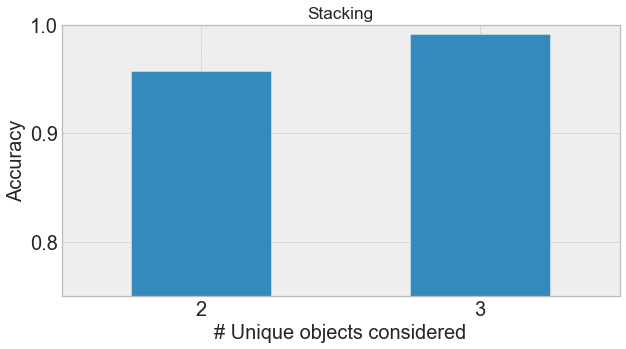

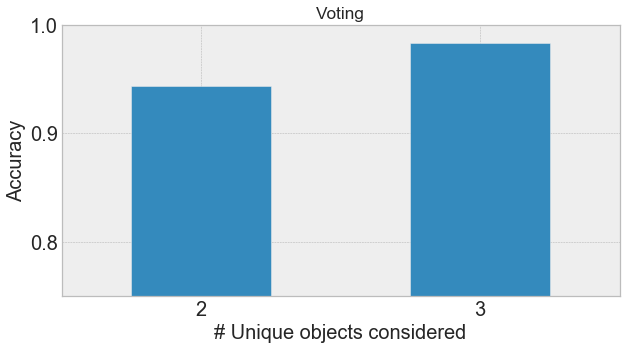

In [10]:
df_bar_plot_stack.columns=['Accuracy']
df_bar_plot_vote.columns=['Accuracy']
plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)
plt.style.use('bmh')

fig, ax = plt.subplots()
pl = df_bar_plot_stack.plot(kind="bar", figsize=(10,5), title="Stacking", ax=ax, rot=0, fontsize=15)
pl.set_xticklabels(("2", "3", "4", "5", "6", "7", "8"))
plt.legend(prop={'size':15})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel('# Unique objects considered', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim([0.75, 1])
ax.get_legend().remove()
fig.savefig('./reports/' + mode + '_fig1' + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')

fig, ax = plt.subplots()
pl = df_bar_plot_vote.plot(kind="bar", figsize=(10,5), title="Voting", ax=ax, rot=0, fontsize=15)
pl.set_xticklabels(("2", "3", "4", "5", "6", "7", "8"))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop={'size':15})
plt.xlabel('# Unique objects considered', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim([0.75, 1])
ax.get_legend().remove()
fig.savefig('./reports/' + mode + '_fig2' + ".pdf", format='pdf', dpi=600, bbox_inches = 'tight')